<a href="https://colab.research.google.com/github/mbarte/AMD/blob/main/GCRegression_Model_AMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GALAXY CLASSIFICATION TASK - REGRESSION**

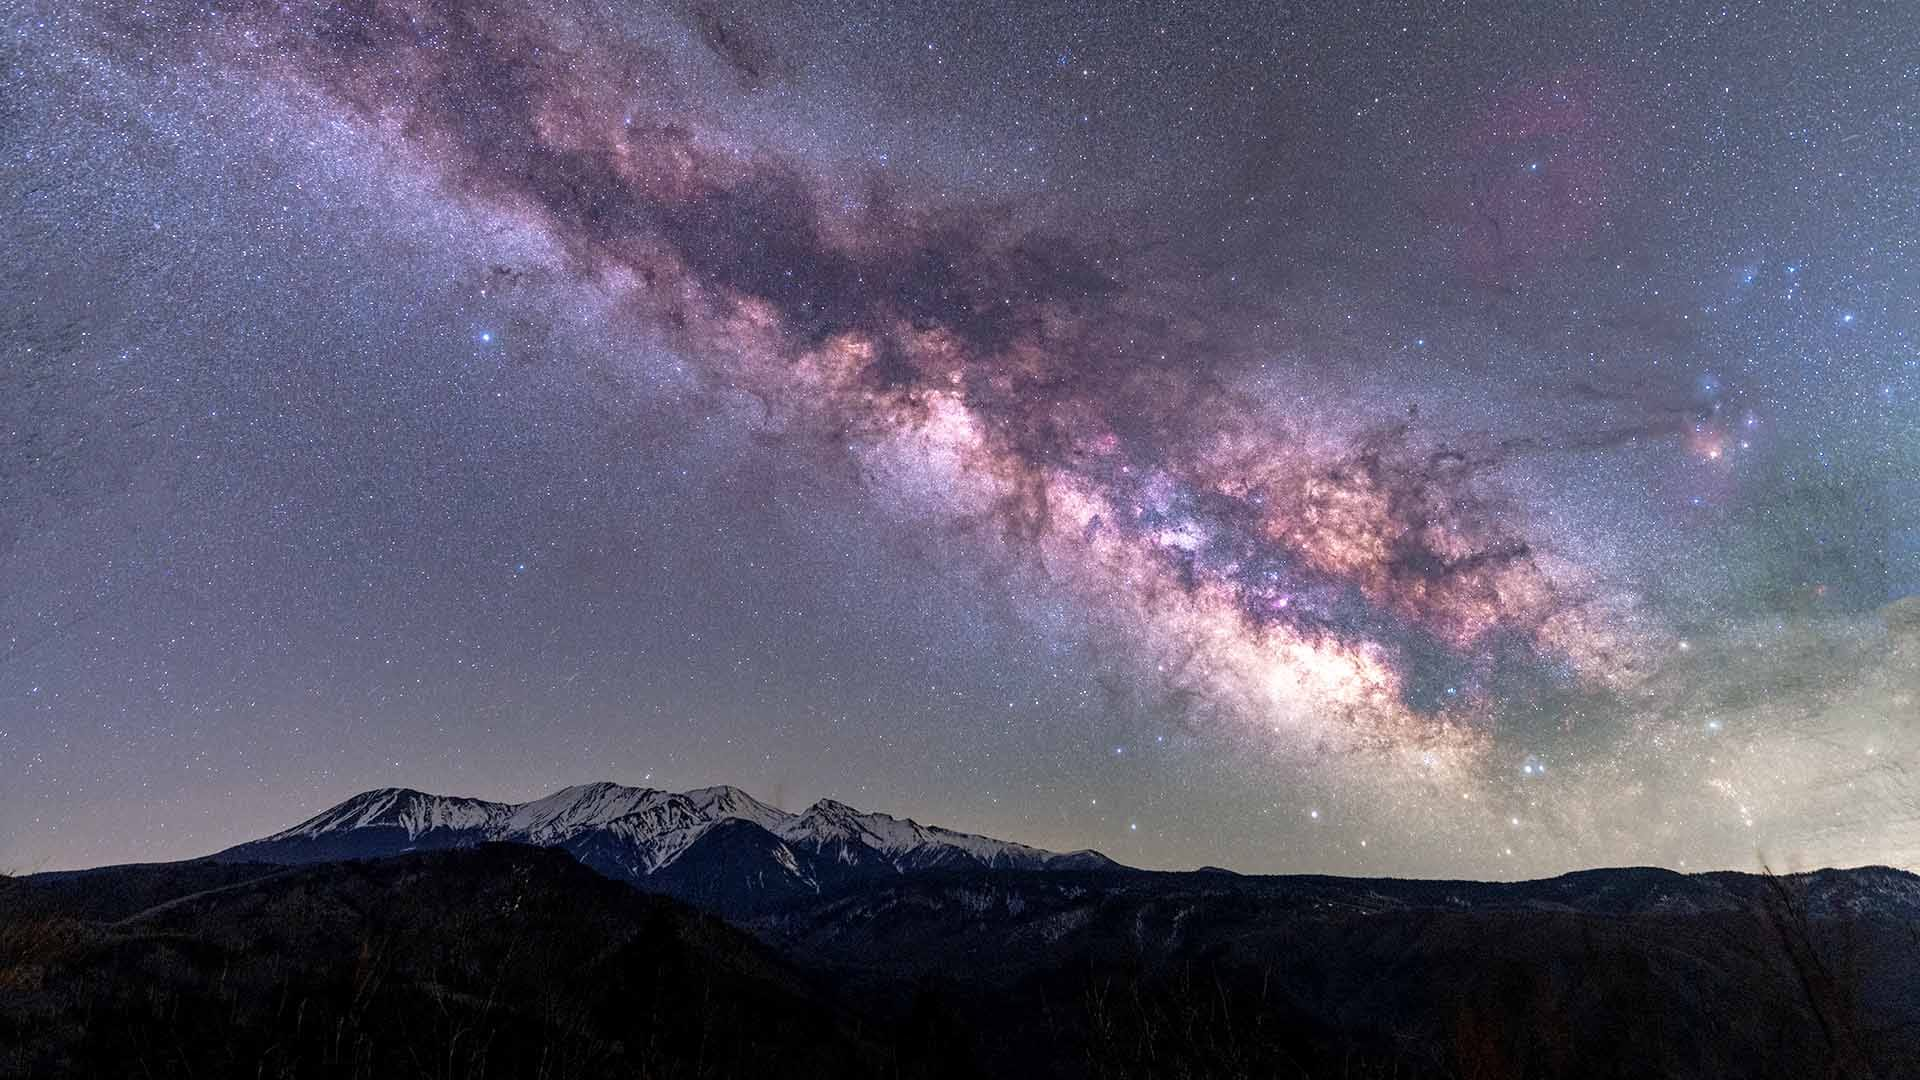

Milky way, credits: https://starwalk.space/en/news/milky-way-galaxy-all-you-need-to-know

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Import the necessary libraries

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import os
import copy
import time
import itertools
import h5py
from random import sample, seed

from sklearn.preprocessing import LabelEncoder

import PIL #import pillow 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers, metrics, losses, callbacks, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

In [ ]:
strategy = tf.distribute.get_strategy()
strategy

# Fully automatic import [Run this to download and unzip the dataset]

In [ ]:
os.environ['KAGGLE_USERNAME'] = "michelebarte" 
os.environ['KAGGLE_KEY'] = "85bdd7673d63f1cd611f2e4cab0e1f6e" 

#Download
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

print("Downloading done!")

 99% 1.76G/1.77G [00:11<00:00, 177MB/s]
100% 1.77G/1.77G [00:11<00:00, 160MB/s]


In [ ]:
#Unzip
start = time.time()

!unzip /content/galaxy-zoo-the-galaxy-challenge.zip                             #-d /content/<folder name> to create a specific folder 

end = time.time()
print("Unzipping done!")
print("The process took {:.2f} hours.".format((end - start)/3600))

Archive:  /content/galaxy-zoo-the-galaxy-challenge.zip
  inflating: all_ones_benchmark.zip  
  inflating: all_zeros_benchmark.zip  
  inflating: central_pixel_benchmark.zip  
  inflating: images_test_rev1.zip    
  inflating: images_training_rev1.zip  
  inflating: training_solutions_rev1.zip  
Unzipping done!
The process took 0.01 hours.


In [ ]:
%%capture                                                                       
#suppress the "inflating filename..." output

start = time.time()

!unzip /content/images_training_rev1.zip                                        #unzip training data
!unzip /content/images_test_rev1.zip                                            #unzip testing data
!unzip /content/training_solutions_rev1.zip                                     #unzip training labels

end = time.time()

print("Unzipping done!")
print("The process took {:.2f} hours.".format((end - start)/3600))

The goal is to classify galaxies in the framework originally proposed by Kaggle. Since I aimed at creating a personal framework, I simply made few modifications to a public submission to compare the empirical results. In particular, I wanted to see how impacting was to normalise images and work with greyscale resized images.

# Functions

In [ ]:
BATCH_SIZE = 128                                                            
#The batch size can be made smaller so that the model will do less coarse steps in order to look for the optimal solution and is more likely to converge to it
#For computational reasons we use a larger one

AUTOTUNE = tf.data.AUTOTUNE                                                     #efficiency reason

- Functions to create the datasets, making use of tensorflow pipelines for efficiency

In [ ]:
#Functions to create the dataset
#-------------------------------------------------------------------------------
def image_preparation(img):
  '''
  Takes the path of the image and encode it as a Tensor, resizing it to exclude other galaxies
  '''
  image = tf.io.decode_image(tf.io.read_file(img), dtype=tf.dtypes.float32)     
  image = tf.image.resize_with_crop_or_pad(image, 100,100)                      #only retain the central galaxy
  image = tf.image.rgb_to_grayscale(image)                                      #greyscale
  image = tf.image.per_image_standardization(image)                             #normalisation
  image = tf.image.resize(image, (50,50))                                       #also resize images 
  return image
#-------------------------------------------------------------------------------  
#-------------------------------------------------------------------------------
def training_preparation(img):
  '''
  input: file (image)
  returns image associated with its label
  '''
  image = image_preparation(img)
  filenum = tf.strings.split(img,  "/")[3]                                      #isolate the number corresponding to the GalaxyID
  id = int(tf.strings.substr(filenum, 0, tf.strings.length(filenum)-4))         #remove .jpg and convert to integer to allow comparison
  row = labels.loc[labels["GalaxyID"] == id]                                    #retrieve the corresponding row in the labels dataframe
  probs = tf.cast(row.iloc[0,1:].values, tf.float32)                            #probabilities of belonging to a certain class

  return image, probs

def compile_training(files):
  files_list_ds = tf.data.Dataset.from_tensor_slices(files)
  dataset = files_list_ds.map(lambda x: tf.py_function(func=training_preparation, inp=[x], Tout=(tf.float32,tf.float32)), num_parallel_calls = AUTOTUNE)

  dataset = dataset.cache()      
  
  dataset = dataset.shuffle(len(dataset), reshuffle_each_iteration = True)      #common practice to increase the power of generalisation
  
  dataset = dataset.batch(BATCH_SIZE) 
  
  dataset = dataset.prefetch(AUTOTUNE)        
                                        
  return dataset

def compile_validation(files):
  files_list_ds = tf.data.Dataset.from_tensor_slices(files)
  dataset = files_list_ds.map(lambda x: tf.py_function(func=training_preparation, inp=[x], Tout=(tf.float32,tf.float32)), num_parallel_calls = AUTOTUNE)

  dataset = dataset.cache()      
  
  dataset = dataset.batch(BATCH_SIZE)

  return dataset
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
def validation_preparation(img):
  '''
  input: file (image)
  returns image associated with its label
  '''
  image = image_preparation(img)
  return image

def compile_test(images_path):
  images_path_ds = tf.data.Dataset.from_tensor_slices(images_path)
  dataset = images_path_ds.map(lambda x: tf.py_function(func=validation_preparation, inp=[x], Tout=(tf.float32,tf.float32)), num_parallel_calls=AUTOTUNE)
        
  dataset.cache()

  dataset = dataset.batch(BATCH_SIZE)
                                        
  return dataset

- Function to plot a few examples from the dataset (images are now normalised and greyscale)

In [ ]:
def plot_example(dataset, rows=2, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    images = list(dataset.take(1).as_numpy_iterator())[0][0]
    labels = list(dataset.take(1).as_numpy_iterator())[0][1]
    for i in range(rows):
        for j in range(cols):
            axes[i,j].grid(False)
            axes[i,j].axis('off')
            axes[i,j].imshow(images[cols*i+j, :])
    plt.show()
    return images[0].shape, labels[0].shape

- Function to build the CNN 

In [ ]:
def reg_model(input_shape):
    model = tf.keras.models.Sequential(name="Regression_Model", layers=[
        layers.Conv2D(filters=16,kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(filters=32,kernel_size=(5, 5),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(filters=64,kernel_size=(3, 3),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(filters=128,kernel_size=(3, 3),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(37, activation='sigmoid')
    ])

    return model

- Function for learning rate scheduling

In [ ]:
def decay_schedule(epoch, lr):
    return lr * 0.8 if (epoch % 10 == 0) and (epoch != 0) else lr

# Preprocessing

For this part of the project I took a random subsample of the files contained in the traning files folder 

In [ ]:
#Return name of files contained in the path (as a list of strings)
files_list = tf.io.gfile.glob("/content/images_training_rev1/*")

sample_size = int(len(files_list)*0.2)
files_list = sample(files_list, sample_size)                                    #using 20% of the files (~12 thousands images)
print("We are now working with: ", len(files_list), " files")
files_list[:3]

We are now working with:  12315  files


['/content/images_training_rev1/685680.jpg',
 '/content/images_training_rev1/941773.jpg',
 '/content/images_training_rev1/776550.jpg']

In [ ]:
#Inspect the training labels
labels = pd.read_csv("/content/training_solutions_rev1.zip")
print("The shape of the dataframe is: ", labels.shape)
labels.head()

#labels.info()   #no null values

The shape of the dataframe is:  (61578, 38)


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


For the regression model reproduction I give credits to the Kaggle user Ushmi (https://www.kaggle.com/eladcohen3)

I did a few modifications to the framework to see the influence of such changes.

- Image normalisation
- Greyscale 


In [ ]:
#Datasets creation 

seed = 123
tf.random.set_seed(seed)
files_list = tf.random.shuffle(files_list)                                      #common practice
size = len(files_list)
print("Number of total samples: {}".format(size))

#instead of splitting the dataset which is harder with a tensor dataset, we split
#the filenames and compile the datasets with the right proportion
train_index = int(np.floor(size*0.8))                                           #80% of data as training
remaining = size - train_index
test_index = int(np.floor(remaining*0.15))                                      #15% of the remaining as test

files_list_train = files_list[remaining:]                                       
files_list_val = files_list[test_index:remaining]                               
files_list_test = files_list[:test_index]                                       

train = compile_training(files_list_train)
print("Training set batches: ",tf.data.experimental.cardinality(train))
val = compile_validation(files_list_val)
print("Validation set cardinality: ", tf.data.experimental.cardinality(val))
test = compile_validation(files_list_test)
print("Test set cardinality: ", tf.data.experimental.cardinality(test))

Number of total samples: 12315
Training set batches:  tf.Tensor(77, shape=(), dtype=int64)
Validation set cardinality:  tf.Tensor(17, shape=(), dtype=int64)
Test set cardinality:  tf.Tensor(3, shape=(), dtype=int64)


Preprocessed images examples


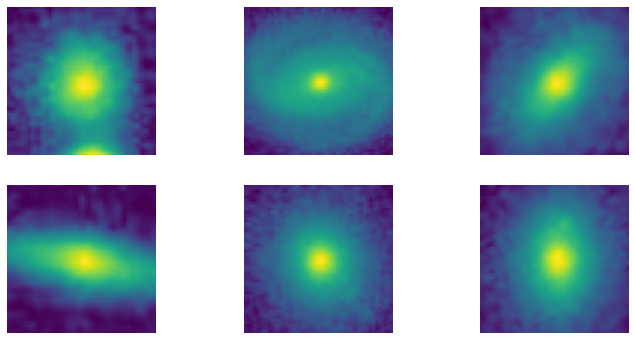

The images shape is: (50, 50, 1)
The features shape is: (37,)


In [ ]:
#Take a look at the images the way they are used to train the model

print("Preprocessed images examples")
image_shape, features_num = plot_example(train)
print("The images shape is: {}".format(image_shape))
print("The features shape is: {}".format(features_num))

Observe that during this step we didn't pay attention to labels frequency because that would be quite complicate, since each node of the classification tree would have a different probability distribution. This also allows to isolate the effect of opting for greyscale normalised images and compare results with the available model (which does not take into account labels stratification as well).

# CNN model

The i-th of the 37 output nodes output a float between 0 and 1, which is the probability of following the path starting from the i-th node in the decision tree. Thus the loss function is the MSE and the accuracy metrics is the RMSE (same unit of measure)

In [ ]:
with strategy.scope(): 
    image_shape = (50,50,1)
    reg_model = reg_model(image_shape)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 
    loss_func = tf.keras.losses.MeanSquaredError()                             
    reg_model.compile(loss=loss_func, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
reg_model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 32)        12832     
                                                                 
 batch_normalization_5 (Batc  (None, 20, 20, 32)  

I used the callbacks in order to make the training process faster

In [ ]:
num_epochs = 25
verbose = True

# Callbacks to make the training both more efficient and faster
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-5)

lr_scheduler = callbacks.LearningRateScheduler(decay_schedule)

early_stop = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=7)

checkpoint = callbacks.ModelCheckpoint('best_model', save_best_only=True, monitor='val_root_mean_squared_error', mode='max')

callbacksInUse = [reduce_lr, lr_scheduler, early_stop, checkpoint]

Train the model

In [ ]:
#Fit the model
print('------- Training -------')
start = time.time()
history = reg_model.fit(train, validation_data=val, epochs=num_epochs, callbacks=callbacksInUse, use_multiprocessing=True, verbose=True)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/25
77/77 [==============================] - ETA: 0s - loss: 0.0370 - root_mean_squared_error: 0.1924

77/77 [==============================] - 251s 997ms/step - loss: 0.0370 - root_mean_squared_error: 0.1924 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1781 - lr: 0.0010
Epoch 2/25
77/77 [==============================] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.1498

77/77 [==============================] - 40s 520ms/step - loss: 0.0224 - root_mean_squared_error: 0.1498 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2027 - lr: 0.0010
Epoch 3/25
77/77 [==============================] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.1395

77/77 [==============================] - 41s 533ms/step - loss: 0.0195 - root_mean_squared_error: 0.1395 - val_loss: 0.0435 - val_root_mean_squared_error: 0.2086 - lr: 0.0010
Epoch 4/25
77/77 [==============================] - 37s 475ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906 - lr: 0.0010
Epoch 5/25
77/77 [==============================] - 38s 487ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1656 - lr: 0.0010
Epoch 6/25
77/77 [==============================] - 37s 478ms/step - loss: 0.0161 - root_mean_squared_error: 0.1270 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1524 - lr: 0.0010
Epoch 7/25
77/77 [==============================] - 36s 470ms/step - loss: 0.0153 - root_mean_squared_error: 0.1239 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1499 - lr: 0.0010
Epoch 8/25
77/77 [==============================] - 37s 481ms/step - loss: 0.0149

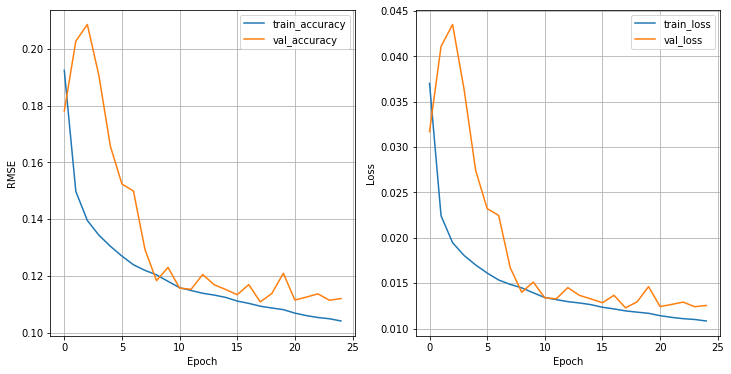

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['root_mean_squared_error'], label='train_accuracy')
axes[0].plot(metrics['val_root_mean_squared_error'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('RMSE')
axes[0].legend(loc='upper right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

Save the model

In [ ]:
reg_model.save("reg_model.h5")
print("Saved model to disk")

Saved model to disk


Test the model

In [ ]:
results = reg_model.evaluate(val, verbose=1)
print("Test RMSE: {:.3f}".format(results[1]))

17/17 [==============================] - 2s 93ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120
Test RMSE: 0.112


In [ ]:
#load model
#reg_model = load_model('reg_model.h5')

There is a decreasing trend, but the model is slightly overfitting. Since the regression framework is not my main goal and the main purpose of this part was to obtain some experimental results, I'll leave it as it is.